# Decomposition Example

First step, set the paths to where to find the motif dictionary and associated code. Note that these are available at http://github.com/sdrogers/motifdb

In [1]:
motifdbcodepath = '/Users/simon/git/motifdb/code/utilities/'
motifdbpath = '/Users/simon/git/motifdb/motifs/'

Load some motifs from the motif database, I'm just loading the massbank ones

In [2]:
import sys
sys.path.append(motifdbcodepath)
from motifdb_loader import load_db
db_list = ['gnps_binned_005']
spectra,motif_metadata = load_db(db_list,motifdbpath)

Looking in /Users/simon/git/motifdb/motifs/gnps_binned_005/*.m2m
	 Found 92
Found total of 92 motif files


spectra is a dictionary with key the filename of the motif and values another dictionary with feature / probability pairs

In [3]:
import numpy as np

make an index of the unique features -- we can only decompose onto features that are loaded from the database

In [4]:
word_index = {}
word_pos = 0
for motif,word_probs in spectra.items():
    for word,probability in word_probs.items():
        if not word in word_index:
            word_index[word] = word_pos
            word_pos += 1

Put the words and motifs into a matrix ($\beta$)

In [5]:
# Create a beta matrix
motif_index = {}
motif_pos = 0
n_motifs = len(spectra)
n_words = len(word_index)
beta = np.zeros((n_motifs,n_words),np.double)
for motif,word_probs in spectra.items():
    motif_index[motif] = motif_pos
    for word,probability in word_probs.items():
        beta[motif_pos,word_index[word]] = probability
    motif_pos += 1

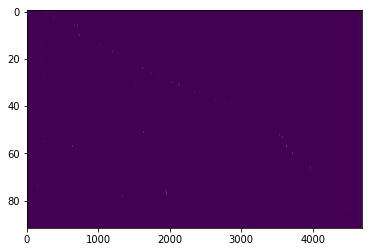

In [6]:
import pylab as plt
%matplotlib inline
plt.imshow(beta,aspect='auto')


Renomalise beta as when we save motifs we threshold on the probabilities and they end up not summing to 1

*Addition*: made sure there were no zeros

In [7]:
    # find the minimum value of beta that isn't zero
    pos = np.where(beta > 0)
    min_val = beta[pos].min()
    zpos = np.where(beta == 0)
    beta[zpos] = min_val/100

In [8]:
beta /= beta.sum(axis=1)[:,None]

Load some data..I'm loading massbank data, but other datasets are available. Also assuming the motifs were made using binned features

In [28]:
ldacodepath = '/Users/simon/git/lda/code/'
sys.path.append(ldacodepath)
from ms2lda_feature_extraction import LoadGNPS,MakeBinnedFeatures

import glob
massbank_data = glob.glob('/Users/simon/Dropbox/BioResearch/Meta_clustering/MS2LDA/fingerid-104-traindata/spectra_massbank/*.ms')
sub_data = massbank_data[:100]
l = LoadGNPS()
ms1,ms2,spectral_metadata = l.load_spectra(sub_data)
m = MakeBinnedFeatures()
corpus,word_mz_range = m.make_features(ms2)
corpus = corpus[corpus.keys()[0]]

Processed 100 spectra
100 documents
After removing empty words, 3695 words left


New code to load from the MGF

In [9]:
ldacodepath = '/Users/simon/git/lda/code/'
sys.path.append(ldacodepath)
from ms2lda_feature_extraction import LoadMGF,MakeBinnedFeatures

mgf_file = '/Users/simon/git/lda/notebooks/clusters.mgf'
l = LoadMGF()
ms1,ms2,spectral_metadata = l.load_spectra([mgf_file])
m = MakeBinnedFeatures()
corpus,word_mz_range = m.make_features(ms2)
corpus = corpus[corpus.keys()[0]]

2331 documents
After removing empty words, 75773 words left


Do the decomposition

Some points to note here:
 - Features in the spectra that are not in the motifs don't add anything to they get skipped. I compute (`proportion_in`) the percentage of intensity that is usable.
 - This should be taken into account when interpreting the spectra-motif probabilities (`theta`). These values can be interpreted as the proportion of the usable part of the spectra, and not the total.
 - I also compute overlap score, as it's useful to see how much of the motif is in the spectrum

This is a handy function to compute the overlap score

In [10]:
def compute_overlap(phi_matrix,motif_pos,beta_row,word_index):
    overlap_score = 0.0
    for word in phi_matrix:
        word_pos = word_index[word]
        overlap_score += phi_matrix[word][motif_pos]*beta_row[word_pos]
    return overlap_score

 - This is the actual decomposition. 
 - The main loop goes over 100 times, this is probably overkill but it jumps out if the total absolute change in `gamma` is less than `1e-6`.
 - This code doesn't compute alpha, but I can add that if necessary
 - I get a warning about a `log(0)`. This is due to some entries in beta being 0, and it doesn't cause any problem, but could be removed by setting all the zero values to somethign very small and then re-normalising the beta matrix.
 - I do some plotting at the end to show how stuff can be exposed
 - If you wanted to see the decomposition at the individual feature level then you would need to keep hold of `phi_matrix` which gives (for each word), the probabilities over each motif.

In [11]:
from scipy.special import psi as psi
theta = {}
K = n_motifs
alpha = 1 # will have some effect, but there's no way to set it. Making it low means we'll get sparse solutions
overlap_scores = {}

doc_scans = []
for doc in corpus:
    doc_scans.append((doc,int(spectral_metadata[doc]['scans'])))
    
doc_scans = sorted(doc_scans,key = lambda x: x[1])
# doc_scans = filter(lambda x: x[1]<=130,doc_scans)
doc_list,scan_list = zip(*doc_scans)

In [12]:
for doc in doc_list:
#     print doc,spectral_metadata[doc]['scans']
    # Compute the proportion of this docs intensity that is represented in the motifs
    total_in = 0.0
    total = 0.0
    doc_dict = corpus[doc]
    for word,intensity in doc_dict.items():
        total += intensity
        if word in word_index:
            total_in += intensity
    proportion_in = (1.0*total_in)/total
#     print '\t',proportion_in
    if proportion_in > 0: # Be careful: if there is no overlap between the features in the spectrum and those across the motifs, bad things might happen
        phi_matrix = {}
        for word in doc_dict:
            if word in word_index:
                phi_matrix[word] = None
        gamma = np.ones(K)
        for i in range(100):
            temp_gamma = np.zeros(K) + alpha
            for word,intensity in doc_dict.items():
                if word in word_index:
                    word_pos = word_index[word]
                    if beta[:,word_pos].sum()>0:
                        log_phi_matrix = np.log(beta[:,word_pos]) + psi(gamma)
                        log_phi_matrix = np.exp(log_phi_matrix - log_phi_matrix.max())
                        phi_matrix[word] = log_phi_matrix/log_phi_matrix.sum()
                        temp_gamma += phi_matrix[word]*intensity
            gamma_change = np.sum(np.abs(gamma - temp_gamma))
            gamma = temp_gamma.copy()
            if gamma_change < 1e-6:
                break
        temp_theta = (gamma/gamma.sum()).flatten()
        theta[doc] = {}
        overlap_scores[doc] = {}
        for motif,motif_pos in motif_index.items():
            theta[doc][motif] = temp_theta[motif_pos]
            overlap_scores[doc][motif] = compute_overlap(phi_matrix,motif_pos,beta[motif_pos,:],word_index)

        # print some things!
        tm = zip(theta[doc].keys(),theta[doc].values())
        tm = sorted(tm,key = lambda x: x[1],reverse = True)
        for mo,th in tm[:3]:
            if overlap_scores[doc][mo]>=0.3:
                print doc,spectral_metadata[doc]['scans'],mo,th,overlap_scores[doc][mo],motif_metadata[mo]['ANNOTATION'][:40]

document_3 7 gnps_motif_53.m2m 0.436664774485 0.818121811933 Imidazole group linked to a carboxylgrou
document_20 92 gnps_motif_57.m2m 0.12675067679 0.869783767108 Fragment ions indicative for alkylamine 
document_24 102 gnps_motif_47.m2m 0.334935213696 0.712569909984 Fragments indicative for histidine (C6H1
document_25 103 gnps_motif_43.m2m 0.320453782177 0.952907846142 Water loss - indicative of a free hydrox
document_28 106 gnps_motif_47.m2m 0.6422365857 0.712587106532 Fragments indicative for histidine (C6H1
document_31 113 gnps_motif_43.m2m 0.115703990472 0.943182378272 Water loss - indicative of a free hydrox
document_36 138 gnps_motif_48.m2m 0.0150461070257 0.954570773263 Fragment ion indicative for conjugation 
document_39 160 gnps_motif_47.m2m 0.603629645667 0.712596735254 Fragments indicative for histidine (C6H1
document_60 193 gnps_motif_47.m2m 0.641822585482 0.712585492377 Fragments indicative for histidine (C6H1
document_60 193 gnps_motif_53.m2m 0.0949325321323 0.818038773

document_171 532 gnps_motif_3.m2m 0.436280585131 0.900336411754 nitrogen containing substructure [C5H12N
document_171 532 gnps_motif_5.m2m 0.218400232397 0.477605811648 Combined loss of H2O and CO – indicati
document_171 532 gnps_motif_38.m2m 0.218400232397 0.477605811648 Loss of CH2O2 - indicative for underivat
document_172 536 gnps_motif_3.m2m 0.455455021622 0.900337133018 nitrogen containing substructure [C5H12N
document_172 536 gnps_motif_5.m2m 0.227860692678 0.477608176359 Combined loss of H2O and CO – indicati
document_172 536 gnps_motif_38.m2m 0.227860692678 0.477608176359 Loss of CH2O2 - indicative for underivat
document_173 537 gnps_motif_3.m2m 0.772431021023 0.955238129712 nitrogen containing substructure [C5H12N
document_173 537 gnps_motif_5.m2m 0.096979751323 0.477590786285 Combined loss of H2O and CO – indicati
document_173 537 gnps_motif_38.m2m 0.096979751323 0.477590786285 Loss of CH2O2 - indicative for underivat
document_174 538 gnps_motif_33.m2m 0.57427885572 0.3771902

document_212 773 gnps_motif_3.m2m 0.687038857242 0.955230658361 nitrogen containing substructure [C5H12N
document_212 773 gnps_motif_5.m2m 0.0823123700694 0.477456179627 Combined loss of H2O and CO – indicati
document_212 773 gnps_motif_38.m2m 0.0823123700694 0.477456179627 Loss of CH2O2 - indicative for underivat
document_213 792 gnps_motif_3.m2m 0.203181809211 0.90030792985 nitrogen containing substructure [C5H12N
document_213 792 gnps_motif_5.m2m 0.102189883158 0.477571200514 Combined loss of H2O and CO – indicati
document_214 830 gnps_motif_3.m2m 0.261671726665 0.900322034993 nitrogen containing substructure [C5H12N
document_214 830 gnps_motif_5.m2m 0.131096950104 0.477595955344 Combined loss of H2O and CO – indicati
document_215 835 gnps_motif_3.m2m 0.382767076721 0.900334211604 nitrogen containing substructure [C5H12N
document_215 835 gnps_motif_5.m2m 0.191615525356 0.477518713234 Combined loss of H2O and CO – indicati
document_215 835 gnps_motif_38.m2m 0.191615525356 0.477518713

document_444 2163 gnps_motif_43.m2m 0.505481651652 0.954740858548 Water loss - indicative of a free hydrox
document_445 2173 gnps_motif_43.m2m 0.399615819584 0.946720778914 Water loss - indicative of a free hydrox
document_446 2185 gnps_motif_59.m2m 0.48982982008 0.917157181273 Fragments indicative for [phenylalanine-
document_447 2187 gnps_motif_43.m2m 0.249412293886 0.949067021627 Water loss - indicative of a free hydrox
document_448 2207 gnps_motif_43.m2m 0.298883276236 0.955117745484 Water loss - indicative of a free hydrox
document_449 2210 gnps_motif_43.m2m 0.287879147664 0.946949337375 Water loss - indicative of a free hydrox
document_450 2229 gnps_motif_43.m2m 0.416863322141 0.954573196014 Water loss - indicative of a free hydrox
document_451 2232 gnps_motif_43.m2m 0.350949792136 0.95513557863 Water loss - indicative of a free hydrox
document_453 2237 gnps_motif_43.m2m 0.778736866724 0.955200645781 Water loss - indicative of a free hydrox
document_454 2242 gnps_motif_43.m2m 0.4

document_1048 8211 gnps_motif_43.m2m 0.267305069212 0.95483945649 Water loss - indicative of a free hydrox
document_1050 8218 gnps_motif_43.m2m 0.254397098526 0.954291766565 Water loss - indicative of a free hydrox
document_1066 8390 gnps_motif_5.m2m 0.0621958595186 0.477547110371 Combined loss of H2O and CO – indicati
document_1073 8469 gnps_motif_24.m2m 0.195951159282 0.304617137247 Fragments indicative for tyrosine relate
document_1076 8480 gnps_motif_24.m2m 0.206943670779 0.300124285422 Fragments indicative for tyrosine relate
document_1098 8763 gnps_motif_49.m2m 0.429812913497 0.955195006773 Loss possibly indicative of carboxylic a
document_1101 8796 gnps_motif_43.m2m 0.168271910395 0.954579431064 Water loss - indicative of a free hydrox
document_1104 8816 gnps_motif_56.m2m 0.259912152872 0.929877005626 Double water loss i.e. 2*H20 – Generic
document_1104 8816 gnps_motif_43.m2m 0.194711089999 0.953983526604 Water loss - indicative of a free hydrox
document_1109 8910 gnps_motif_13.

document_1699 23707 gnps_motif_64.m2m 0.178044342183 0.305927395789 phthalate substructure
document_1705 23794 gnps_motif_64.m2m 0.673456428944 0.311694311264 phthalate substructure
document_1709 23828 gnps_motif_64.m2m 0.448612725793 0.307297918626 phthalate substructure
document_1710 23880 gnps_motif_21.m2m 0.0497185651739 0.585652835996 Fragments indicative for ethylphenol sub
document_1718 24156 gnps_motif_56.m2m 0.189734919222 0.939689884279 Double water loss i.e. 2*H20 – Generic
document_1719 24189 gnps_motif_47.m2m 0.0983129386337 0.712498022609 Fragments indicative for histidine (C6H1
document_1721 24195 gnps_motif_170.m2m 0.35960305067 0.584694104217 methoxy-methylaminophenyl substructure
document_1737 24438 gnps_motif_52.m2m 0.0713585068894 0.951775375639 Fragment indicative for aromatic compoun
document_1739 24483 gnps_motif_42.m2m 0.174144921525 0.903498290853 Fragments indicative adenine (C5H6N5) su
document_1740 24496 gnps_motif_5.m2m 0.0387874708783 0.477352253258 Combin

In [27]:
print scan_list

(1, 3, 7, 8, 9, 11, 12, 18, 19, 20, 22, 40, 44, 45, 46, 49, 55, 84, 88, 92, 93, 94, 96, 102, 103, 104, 105, 106, 107, 110, 113, 118, 119, 120)
